In this notebook, we incorporate architectural improvements to the LLM from the previous part. While code changes are minor, understanding the rationale is crucial. We'll discuss these changes and provide helpful resources:

- RMSNorm (instead of LayerNorm)
- Pre-LN and Post-LN
- Gated FFN - SwiGLU
- RoPE
- Minor Attention block changes will be discussed in a separate notebook for comparison (Sliding Window, Multimodal, MoE, etc.).

# Setup

The model architecture is copied directly from Part 1.

In [1]:
!pip install -Uq torch
!pip install -Uq datasets tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Misc
import math
import tiktoken
from tqdm.notebook import tqdm
from datasets import load_dataset
from dataclasses import dataclass
from prettytable import PrettyTable

In [3]:
class MultiheadAttention(nn.Module):
    def __init__(self, emb_dim, heads, context):
        super().__init__()
        assert emb_dim % heads == 0, "`emb_dim` should be a multiple of `heads`"
        self.context = context
        self.mha = nn.MultiheadAttention(emb_dim, heads, batch_first=True, bias=False)
        self.register_buffer("mask", torch.triu(torch.ones(context, context), diagonal=1).bool())

    def forward(self, x):
        batch, seq_len, _ = x.shape
        seq_len = min(seq_len, self.context)
        attn_mask = self.mask[:seq_len, :seq_len]
        attn_out, _ = self.mha(x,x,x,attn_mask=attn_mask, need_weights=False)
        return attn_out

class Block(nn.Module):
    def __init__(self, emb_dim, heads, context):
        super().__init__()
        self.mha = MultiheadAttention(emb_dim, heads, context)
        self.mlp = nn.Sequential(
                        nn.Linear(emb_dim, 4 * emb_dim),
                        nn.GELU(),
                        nn.Linear(4 * emb_dim, emb_dim)
                    )
        self.mha_norm = nn.LayerNorm(emb_dim)
        self.mlp_norm = nn.LayerNorm(emb_dim)

    def forward(self, x):
        x = x + self.mha(self.mha_norm(x))
        x = x + self.mlp(self.mlp_norm(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.pos_embedding = nn.Embedding(config.context, config.emb_dim)
        self.tok_embedding = nn.Embedding(config.vocab, config.emb_dim)
        self.decoder = nn.Sequential(*[Block(config.emb_dim, config.heads, config.context)
                                        for _ in range(config.layers)])
        self.output = nn.Linear(config.emb_dim, config.vocab, bias=False)
        self.norm = nn.LayerNorm(config.emb_dim)

    def forward(self, x):
        batch, seq_len = x.shape
        pos = torch.arange(seq_len, device=x.device)
        x = self.tok_embedding(x) + self.pos_embedding(pos)
        x = self.decoder(x)
        return self.output(self.norm(x))

    @property
    def device(self):
        return next(self.parameters()).device

In [4]:
# Utility Function: Number of Trainable Parameters
def count_parameters(model, verbose=False):
    if verbose:
        table = PrettyTable(["Module", "Parameters"])
        total = 0
        for name, param in model.named_parameters():
            if param.requires_grad:
                count = param.numel()
                table.add_row([name, count])
                total += count
        print(table)
    else:
        total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Params: {total / 1e6:.2f} M")

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

@dataclass
class ModelConfig:
    # GPT2 architecture
    vocab: int   = math.ceil(50_257 / 64) * 64 # nearest multiple of 64
    emb_dim: int = 768
    heads: int   = 12
    layers: int  = 12
    context: int = 1024

In [ ]:
model = GPT(ModelConfig)
model = model.to(device)
count_parameters(model)

# 1. RMSNorm

This is a simple change: replace `nn.LayerNorm` with `nn.RMSNorm`, which applies Root Mean Square Layer Normalization over a mini-batch of inputs.

* Learn more from the [PyTorch RMSNorm docs](https://pytorch.org/docs/stable/generated/torch.nn.RMSNorm.html).
* For deeper insights and empirical results, see the [RMSNorm paper](https://arxiv.org/pdf/1910.07467).


# 2. Post / Pre Normalization

The original Transformer (from the *"Attention Is All You Need"* paper) placed normalization layers **after** the attention and feedforward modules—this is known as **Post-Norm**.

GPT and most later LLMs use **Pre-Norm**, placing normalization layers **before** these modules.

In [2020, Xiong et al.](https://arxiv.org/abs/2002.04745) showed that Pre-Norm leads to more stable gradients at initialization and can perform well without careful learning rate warm-up—unlike Post-Norm.

From an implementation standpoint, the change is minor: just swap the order of operations.

> **Note:** We're already using Pre-Norm here, so no code changes are needed.

In [ ]:
# Post Norm
class BlockPostNorm(Block):
    def forward(self, x):
        x = x + self.mha_norm(self.mha(x))
        x = x + self.mlp_norm(self.nlp(x))

# Pre Norm
class BlockPostNorm(Block):
    def forward(self, x):
        x = x + self.mha(self.mha_norm(x))
        x = x + self.mlp(self.nlp_norm(x))

# 3. SwiGLU

Again, this is a small change to the FFN in the transformer block. Instead of a two-layer feedforward network with GeLU activation, we use SwiGLU.

It’s a short and easy-to-read paper: [GLU Variants Improve Transformer](https://arxiv.org/pdf/2002.05202)



In [6]:
class GatedFFN(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.w1 = nn.Linear(emb_dim, 4 * int(2/3 * emb_dim), bias=False)
        self.w3 = nn.Linear(emb_dim, 4 * int(2/3 * emb_dim), bias=False)
        self.w2 = nn.Linear(4 * int(2/3 * emb_dim), emb_dim, bias=False)
        self.silu_act = nn.SiLU()

    def forward(self, x):
        x = self.silu_act(self.w1(x)) * self.w3(x)
        return self.w2(x)

Here's an excerpt from the paper explaining the rationale behind the `2/3` scaling factor. However, you can choose to ignore it—it was used mainly for apples-to-apples comparison in the paper.


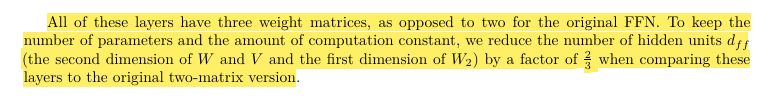

At this point, the updated Transformer block (aka `Block` class) looks like this:

In [7]:
class Block(nn.Module):
    def __init__(self, emb_dim, heads, context):
        super().__init__()
        self.mha = MultiheadAttention(emb_dim, heads, context)
        self.mlp = GatedFFN(emb_dim)        # <--- update
        self.mha_norm = nn.RMSNorm(emb_dim) # <--- update
        self.mlp_norm = nn.RMSNorm(emb_dim) # <--- update

    def forward(self, x):
        x = x + self.mha(self.mha_norm(x))
        x = x + self.mlp(self.mlp_norm(x))
        return x

# 4. RoPE

In the basic implementation, we use absolute position embeddings, as introduced in the original paper. However, things have evolved, and the current norm is to use relative position embeddings. Among various approaches, RoPE has become the dominant choice.

Incorporating RoPE requires more than just a few line changes. It might seem overwhelming, but it’s quite simple once you understand it. We essentially apply a transformation to our `Q` and `K` vectors before the attention operation.

Let’s first define the transformation.


In [8]:
def compute_freqs(dim, context_length, base=10_000):
    assert dim % 2 == 0, "Embedding dimension should be even"
    inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim)) # shape: (1, dim//2)
    pos_ids = torch.arange(context_length)      # shape: (context_len)
    thetas = pos_ids.unsqueeze(1) * inv_freq              # shape: (context_len, dim//2)
    thetas = torch.cat([thetas, thetas], dim=1) # shape: (context_len, dim)
    return thetas.cos(), thetas.sin()

def apply_rope(x, cos, sin):
    batch_size, heads, seq_len, emb_dim = x.shape
    x1, x2 = x[..., :emb_dim//2], x[..., emb_dim//2:]
    rotated = torch.cat([-x2, x1], dim=-1)
    cos, sin = cos[:seq_len, :], sin[:seq_len, :]
    x_rotated = (x * cos) + (rotated * sin)
    return x_rotated.to(dtype=x.dtype)

If the above code looks cryptic, please refer to my detailed notebook on RoPE. It implements RoPE in gradual steps to build better intuition, includes visuals, and compares different implementations.

**Note:** Here, we follow the HuggingFace implementation of RoPE, as I plan to load the model weights from HF.

An important point about RoPE: unlike positional embeddings added once at the beginning, RoPE is applied in every transformer block.

In [9]:
class MultiheadAttention(nn.Module):
    def __init__(self, emb_dim, heads, context):
        super().__init__()
        assert emb_dim % heads == 0, "`emb_dim` should be a multiple of `heads`"
        self.heads = heads
        self.head_dim = emb_dim // heads
        self.qkv_proj = nn.Linear(emb_dim, 3 * emb_dim, bias=False)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=False)
        # RoPE and Casual Mask
        cos, sin = compute_freqs(self.head_dim, context)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)
        self.register_buffer("mask", torch.triu(torch.ones(context, context), diagonal=1).bool())

    def forward(self, x):
        batch, seq_len, emb_dim = x.shape
        qkv = self.qkv_proj(x)
        qkv = qkv.view(batch, seq_len, 3, self.heads, self.head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4) # (3, batch, heads, seq_len, dim)
        q, k = apply_rope(q, self.cos, self.sin), apply_rope(k, self.cos, self.sin)
        attn = (q @ k.mT) / (self.head_dim ** 0.5)
        mask = self.mask[:seq_len, :seq_len]
        attn = attn.masked_fill(mask, float("-inf"))
        attn_out = torch.softmax(attn, dim=-1) @ v
        attn_out = attn_out.transpose(1,2)
        attn_out = attn_out.reshape(batch, seq_len, -1)
        return self.out_proj(attn_out)

class Block(nn.Module):
    def __init__(self, emb_dim, heads, context):
        super().__init__()
        self.mha = MultiheadAttention(emb_dim, heads, context)
        self.mlp = GatedFFN(emb_dim)
        self.mha_norm = nn.RMSNorm(emb_dim)
        self.mlp_norm = nn.RMSNorm(emb_dim)

    def forward(self, x):
        x = x + self.mha(self.mha_norm(x))
        x = x + self.mlp(self.mlp_norm(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        # self.pos_embedding = nn.Embedding(config.context, config.emb_dim) # <--- update
        self.tok_embedding = nn.Embedding(config.vocab, config.emb_dim)
        self.decoder = nn.Sequential(*[Block(config.emb_dim, config.heads, config.context)
                                        for _ in range(config.layers)])
        self.output = nn.Linear(config.emb_dim, config.vocab, bias=False)
        self.norm = nn.RMSNorm(config.emb_dim)    # <--- update

    def forward(self, x):
        batch, seq_len = x.shape
        # pos = torch.arange(seq_len, device=x.device)         # <--- update
        x = self.tok_embedding(x)  # + self.pos_embedding(pos) # <--- update
        x = self.decoder(x)
        return self.output(self.norm(x))

    @property
    def device(self):
        return next(self.parameters()).device

In [10]:
model = GPT(ModelConfig)
model = model.to(device)
count_parameters(model)

Total Trainable Params: 162.22 M


We have about 0.85 million fewer parameters, mainly by removing `pos_embedding`. We also eliminated bias in `GatedFFN`, and unlike `LayerNorm`, `RMSNorm` has no bias.

With these changes, let’s train the model and see if we get better scores and, consequently, better generations.


# Training

In [11]:
tokenizer = tiktoken.get_encoding("gpt2")
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

val_ds = "\n\n".join(dataset["test"]["text"])
train_ds = "\n\n".join(dataset["train"]["text"])

val_tokens = tokenizer.encode(val_ds)
train_tokens = tokenizer.encode(train_ds)
len(val_tokens), len(train_tokens)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

(287644, 2428601)

In [12]:
class WikiTextDataset(Dataset):
    def __init__(self, tokens, max_len):
        self.tokens = tokens
        self.max_len = max_len

    def __getitem__(self, idx):
        idx = idx * self.max_len
        x = self.tokens[idx: idx + self.max_len]
        y = self.tokens[idx+1: idx+1 + self.max_len]
        if len(x) < self.max_len:
            x = x + [tokenizer.eot_token] * (self.max_len - len(x))
        if len(y) < self.max_len:
            y = y + [tokenizer.eot_token] * (self.max_len - len(y))
        return (torch.tensor(x),torch.tensor(y))

    def __len__(self):
        return math.ceil(len(self.tokens)/self.max_len)

batch_size = 4
val_ds = WikiTextDataset(val_tokens, ModelConfig.context)
train_ds = WikiTextDataset(train_tokens, ModelConfig.context)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)

In [13]:
@torch.no_grad()
def generate(model, tokenizer, prefix, max_new_tokens=10, temp=1.0):
    model.eval()
    token_ids = torch.tensor(tokenizer.encode(prefix), device=device).unsqueeze(0)
    for _ in range(max_new_tokens):
        logits = model(token_ids)
        logits = logits[:, -1, :]
        probs = torch.softmax(logits / temp, dim=-1)  # <-- update: scale using temp
        next_idx = torch.multinomial(probs, num_samples=1)
        prefix += tokenizer.decode([next_idx])
        token_ids = torch.cat((token_ids, next_idx), dim=1)
    return prefix

@torch.no_grad()
def evaluate(model, dl):
    model.eval()
    loss = 0
    for (x,y) in dl:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss += F.cross_entropy(logits.flatten(0, 1), y.flatten()).cpu().item()
    model.train()
    return loss / len(dl)

model.to(device)
evaluate(model, val_dl)

10.986594227382115

In [ ]:
prefix = "Once upon a time"
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
log_freq = 40
epochs = 2
losses = []

for epoch in range(epochs):
    for i, (x,y) in enumerate(pbar := tqdm(train_dl, desc="Training")):
        if i % log_freq == 0:
            val_loss = evaluate(model, val_dl)
            losses.append(val_loss)
            pbar.set_postfix_str(f"[Epoch {epoch}] Val Loss: {val_loss:.3f}")
            torch.save(model.state_dict(), "model.pth")
            print("="*20)
            print(generate(model, tokenizer, prefix))

        model.train()
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits.flatten(0,1), y.flatten())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Training:   0%|          | 0/593 [00:00<?, ?it/s]

Once upon a time LuckilyhimUAL populations nickel Calif controlling helligent bisexual
Once upon a timealeb:#inance rear , the the declared This .
Once upon a time government , thin , but Representatives for the creationiers
Once upon a timegars scenarioliest more while opinionank for a down
Once upon a time Ash way despite itself , has hiatus and appeared to
Once upon a time weekly . 

 relational head Cer Unique , including
Once upon a time . official sitting one @ about m came months ,
Once upon a time taken from F victory and two @-@ previous
Once upon a time . The neither military Light par cargo , mined in
Once upon a time . Many Chronicle George . NYU ; 61 2007 ,
Once upon a time , making that194 art icea sought , G
Once upon a time in with aistically to list . The standpoint ,
Once upon a time of Cle policies . 


 Allics was
Once upon a time was seeking as with German bouncing projects the generation that
Once upon a timeatagables near as well ; " I developed


Training:   0%|          | 0/593 [00:00<?, ?it/s]

Once upon a time . Lewis passed responsible for simplyuca during the sermon
Once upon a time to live as the D BJians .�asa
Once upon a time @.@ Via 1989 miracles . It also composed
Once upon a time as Mosley , the bestSU Creek Corpsus
Once upon a time after Daances associations , to died in late Water
Once upon a time manage ranked it summoned up in the interest of Hart
Once upon a time of its police officers , the fundamental priest of Months
Once upon a time on the slide . Mte became the match of
Once upon a time . alkie has antered overall with one of
Once upon a time . Other emplam Ding XIV , missiles ,
Once upon a time piece before the Mediterraneanam singles was both won the
Once upon a time of a home of the treaty . The message of
Once upon a time . 


 Commun 's stage , Rolling
Once upon a time the award . At sand mounted , in the outbreak
Once upon a time of Suprememe later . According to the ruptureopter


In [ ]:
state_dict = torch.load("model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
print(generate(model, tokenizer, "Once upon a time"))
print("="*15)
print(generate(model, tokenizer, "Internet is an"))
print("="*15)
print(generate(model, tokenizer, "AI will"))
print("="*15)
print(generate(model, tokenizer, "The meaning of life is"))

Once upon a time of Boise State , unconditional , triangle ; the Canadian
Internet is an episode where it disclosed episode eyewitness them about Nirvana .
AI will be seen over Jam Video , meaning " Coil profiling
The meaning of life is attached to find itceanarse . 





# Gradient Accumulation

The generations are still not very good. Generally, larger batches help when training LLMs, but we’re limited by memory here.

Gradient Accumulation is a simple way to effectively increase the batch size.

In [ ]:
model = GPT(ModelConfig)
model = model.to(device)

In [14]:
prefix = "Once upon a time"
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
log_freq = 40
epochs = 2
losses = []
accumulate = 4

for epoch in range(epochs):
    for i, (x,y) in enumerate(pbar := tqdm(train_dl, desc="Training")):
        if i % log_freq == 0:
            val_loss = evaluate(model, val_dl)
            losses.append(val_loss)
            pbar.set_postfix_str(f"[Epoch {epoch}] Val Loss: {val_loss:.3f}")
            torch.save(model.state_dict(), "model.pth")
            print("="*20)
            print(generate(model, tokenizer, prefix))

        model.train()
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits.flatten(0,1), y.flatten())
        loss /= accumulate  # <--- Update

        # Backward pass
        loss.backward()
        if (i + 1) % accumulate == 0:  # <--- Update
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

Training:   0%|          | 0/593 [00:00<?, ?it/s]

Once upon a timeegg pollingividuallyStudents trianglesaretz Wish goodwill########legraph
Once upon a time Nintendo leasing 385 2013 traditionalimm implementationxi deportINESS
Once upon a time Echoes Show drive entrflight Otttap coumouth Adobe
Once upon a time psychic SMS tries employee noted miles , two Bezos appoint
Once upon a time of published – absolutelyem icons of the [*laun
Once upon a time College , and the Hayes st , 1921 ,Wild
Once upon a time theiter ceremonyler attire of Conf same that end
Once upon a time . Gloves supported Caps and travelers bandits arrived June .
Once upon a time replied using know Roberto Collegeorial Norway enzymes thought in
Once upon a time of thecuts Be suits . Scholar infantry differently crossed
Once upon a timeima . " 

 designation "andro " .
Once upon a timeook that this acquired MK Michiganians Commission civilizations
Once upon a time . The San trunkational adverse Camp Sick farms are
Once upon a time of the first theoretical that academic l

Training:   0%|          | 0/593 [00:00<?, ?it/s]

Once upon a time of B Boot injectingatops Darkdal .groupon
Once upon a time of its Royal and dealt with leaving moreops or
Once upon a time of watersi . inconveniencebling NOfaces Fleet imagination
Once upon a time . endifü Best trimmed relationship Universe fle�                
Once upon a time on a black 33 storyline . Duringк since the
Once upon a time member of Hyundai . Feel affected were even Will unresolved
Once upon a time when down the Unitedideut ofement Wright that
Once upon a time work .Traclesachers 'iling traits that it
Once upon a time strafamous 's ivory served their clergy behind him
Once upon a time largelyNorthern defeated be himself to to arranged human battles
Once upon a time for the northern Kramer Andyion s ( Ib )
Once upon a time of a tenained , Pet after his 1965 '
Once upon a time of exposure . Like a charity rather starring region at
Once upon a time ; he noted that they linguistic suicide Z undertaken book
Once upon a time. icon travelled and 1930 away to b

In [15]:
state_dict = torch.load("model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
print(generate(model, tokenizer, "Once upon a time"))
print("="*15)
print(generate(model, tokenizer, "Internet is an"))
print("="*15)
print(generate(model, tokenizer, "AI will"))
print("="*15)
print(generate(model, tokenizer, "The meaning of life is"))

Once upon a time of P boxed to beers , a public middle from
Internet is an piano respondents to have been 320lt and other league
AI will vex using choeloor novelty techniques from the novel
The meaning of life is the giving per turbines Kirklled Road . unidentified substrate


# Automatic Mixed Precision (AMP)

AMP is another technique to speed up training by using mixed precision instead of float32. It doesn’t reduce memory much but can speed up training. See the [paper](https://arxiv.org/pdf/1710.03740).

In PyTorch, it’s easy to implement: wrap the forward pass in `torch.autocast()`. For the backward pass, scale the loss with `scaler.scale(loss).backward()` and use `scaler.step(optimizer)` instead of `optimizer.step()`.


In [ ]:
model = GPT(ModelConfig)
model = model.to(device)

In [19]:
@torch.no_grad()
def evaluate(model, dl):
    model.eval()
    loss = 0
    for (x,y) in dl:
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type=device):  # <--- Update
            logits = model(x)
            loss += F.cross_entropy(logits.flatten(0, 1), y.flatten()).cpu().item()
    model.train()
    return loss / len(dl)

In [22]:
prefix = "Once upon a time"
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
log_freq = 40
epochs = 2
losses = []
accumulate = 4
scaler = torch.GradScaler()

for epoch in range(epochs):
    for i, (x,y) in enumerate(pbar := tqdm(train_dl, desc="Training")):
        if i % log_freq == 0:
            val_loss = evaluate(model, val_dl)
            losses.append(val_loss)
            pbar.set_postfix_str(f"[Epoch {epoch}] Val Loss: {val_loss:.3f}")
            torch.save(model.state_dict(), "model.pth")
            print("="*20)
            print(generate(model, tokenizer, prefix))

        model.train()
        x, y = x.to(device), y.to(device)
        with torch.autocast(device_type=device):  # <--- Update
            logits = model(x)
            loss = F.cross_entropy(logits.flatten(0,1), y.flatten())
        loss /= accumulate

        # Backward pass
        scaler.scale(loss).backward()  # <--- Update
        if (i + 1) % accumulate == 0:
            scaler.step(optimizer)  # <--- Update
            scaler.update()         # <--- Update
            optimizer.zero_grad(set_to_none=True)

Training:   0%|          | 0/593 [00:00<?, ?it/s]

Once upon a time planet into Nigel and at Dublin . The sane in
Once upon a time in Wolver disc , including into a @.@
Once upon a time whereboats one qualified proteins would have composed . Twins
Once upon a time of opportunities before ever Daily Vote Treaty of sustain a
Once upon a time @-@ page triple @-@ incident substance
Once upon a time that Barth rigging mentioned by children and Fig . She
Once upon a time of the third @-@ 45 companies productions .
Once upon a time one of 12 @-@ 58 , the that
Once upon a time of the second season , which animal became Ge reciprocal
Once upon a time to the 1930s , to form a guard ,
Once upon a time in the United total . 


 Major fixtures
Once upon a time with a position . This was inf publishers in a
Once upon a time of 9 @,@ 000 riders use of 800
Once upon a time position , spattines and disagree their of another
Once upon a time being were due to as a full problems . They


Training:   0%|          | 0/593 [00:00<?, ?it/s]

Once upon a time with Char space for almost adopt group , Hob Ket
Once upon a time to cause a West Species of wonderful eighth sculptde
Once upon a time under twenty games that fired a new viol Dest very
Once upon a time he wrote to Bl copyrighted about the second part of
Once upon a time in reports . 1920 her own : Belle enough to
Once upon a time of Vietnam Mywn hall . In spite of Jane
Once upon a time or a set with a pair of homes about what
Once upon a time to even two nucle municipal Curtis . All further long
Once upon a time at one time , a strong predecessor when such practical
Once upon a time involved by playing in lying with its fate . The
Once upon a time they 's film , featuring a great whole career
Once upon a time Nish existed byBorn timber a Virtuallets predicted sun
Once upon a time to think they used some intellectuals or possibly lesser people
Once upon a time over Zwe where picked all the doll was already
Once upon a time . 


 hitherto that makes a small personality

In [23]:
state_dict = torch.load("model.pth", map_location=device, weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [24]:
print(generate(model, tokenizer, "Once upon a time"))
print("="*15)
print(generate(model, tokenizer, "Internet is an"))
print("="*15)
print(generate(model, tokenizer, "AI will"))
print("="*15)
print(generate(model, tokenizer, "The meaning of life is"))

Once upon a time . The cow is buried in 2004 , continuing reg
Internet is an 346 or anotheranes storage alastingschrou
AI will , checking specifies or baters , on nuclear whip
The meaning of life is estimated to Wyoming . 


 England and element


Another improvement we could add is a learning rate scheduler, but I'll leave that for now. It's also time to add WandB logging to track our training progress.